In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import lightgbm as lgb

In [66]:
def generate_synthetic_data(n_samples=1000):
    np.random.seed(42)
    
    # Ana özellikler
    feature_1 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_2 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_3 = np.random.uniform(low=-2, high=2, size=n_samples)
    feature_4 = np.random.normal(loc=0, scale=1, size=n_samples)
    feature_5 = np.random.normal(loc=0, scale=1, size=n_samples)
    
    # Hedef değişkeni oluştur (çeşitli gizli etkileşimlerle ve koşullu durumlarla)
    target = (
        0.5 * np.where(feature_1 > 0, feature_2, -feature_2) +  # Koşullu etkileşim: feature_1 > 0 olunca feature_2 pozitif etkiliyor, aksi halde negatif
        0.3 * np.maximum(feature_2, feature_3) +  # En büyük olan feature'ı seçip pozitif etki veriyoruz
        0.6 * (feature_4) ** 2 + 
        0.3 * np.sin(feature_4) * np.sin(feature_5) +  # Sinüs ve kosinüs çarpımı
        np.random.normal(loc=0, scale=0.1, size=n_samples)  # Gürültü ekleyelim
    )
    
    # Hedef değişkeni ikili sınıflandırma için dönüştür
    target_binary = (target > target.mean()).astype(int)
    
    # DataFrame oluştur
    df = pd.DataFrame({
        'feature_1': feature_1,
        'feature_2': feature_2,
        'feature_3': feature_3,
        'feature_4': feature_4,
        'feature_5': feature_5,
        'target': target_binary
    })
    
    return df

# Veri setini oluştur
df = generate_synthetic_data(n_samples=10000)

# Eğitim ve test setlerine ayır
X = df.drop('target', axis=1).values
y = df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [67]:
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters for LightGBM
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "max_depth": 4,
    "feature_fraction": 0.9,
}

# Train the model
num_round = 100
model = lgb.train(params, train_data, num_round, valid_sets=[test_data])

[LightGBM] [Info] Number of positive: 3318, number of negative: 4682
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.414750 -> initscore=-0.344363
[LightGBM] [Info] Start training from score -0.344363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

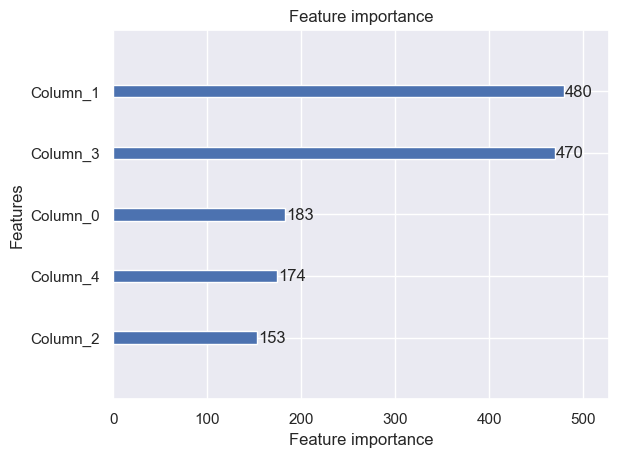

In [68]:
lgb.plot_importance(model)

In [69]:
from tree_explainer import Explainer
from tree_explainer import plot_bar, plot_values_points, plot_dependecy, plot_points, plot_feature, plot_hexbin

In [70]:
tree = Explainer()
tree(model)

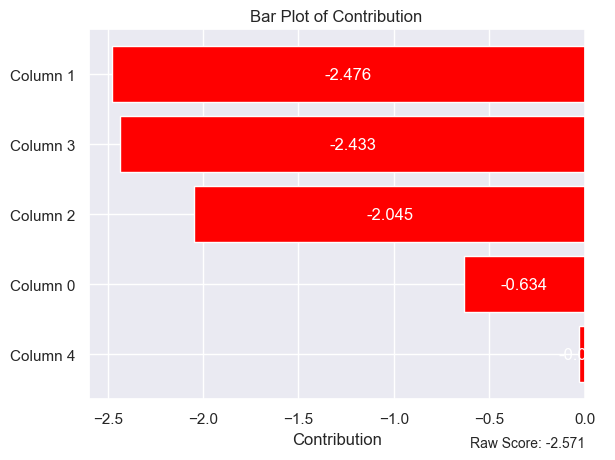

In [71]:
i = 7

values, raw_score = tree.analyze_row(X_train[[5], :], detailed=False)
plot_bar(values, raw_score)

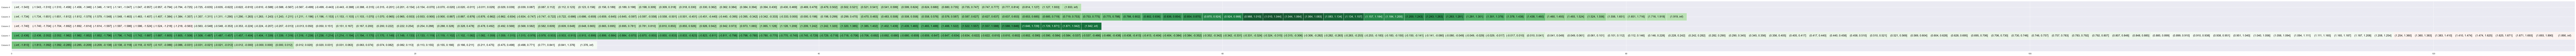

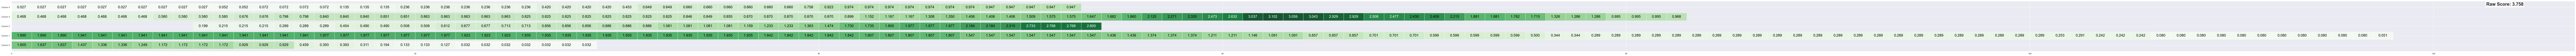

In [72]:
values, points, raw_score = tree.analyze_row(X_train[[i], :], detailed=True)

plot_points(values, points)

plot_values_points(values, raw_score, points)


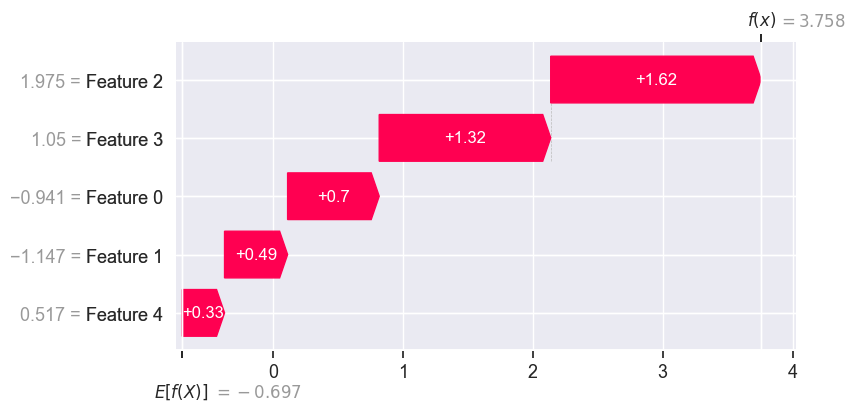

In [73]:
import shap
explainer = shap.TreeExplainer(model, X_train)
shap_values = explainer(X_train)

shap.waterfall_plot(shap_values[i], 20)

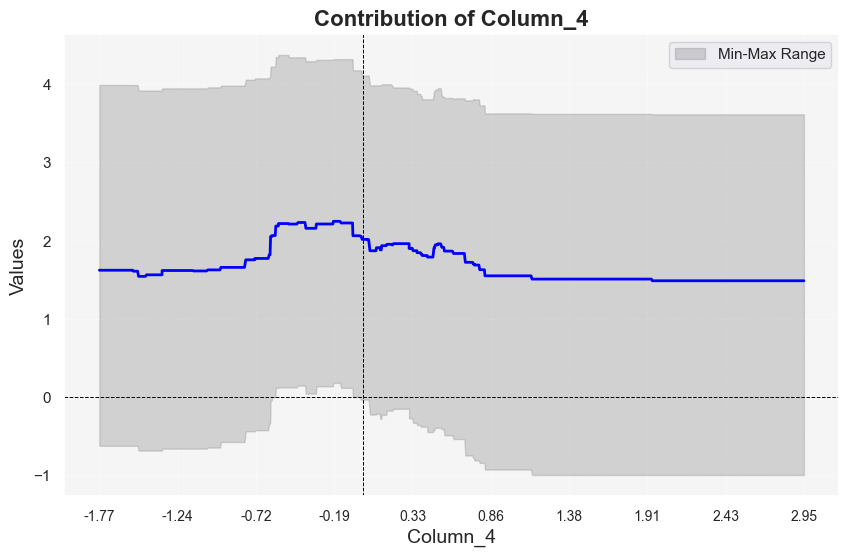

In [80]:
df = tree.analyze_feature(4)

plot_feature(df)

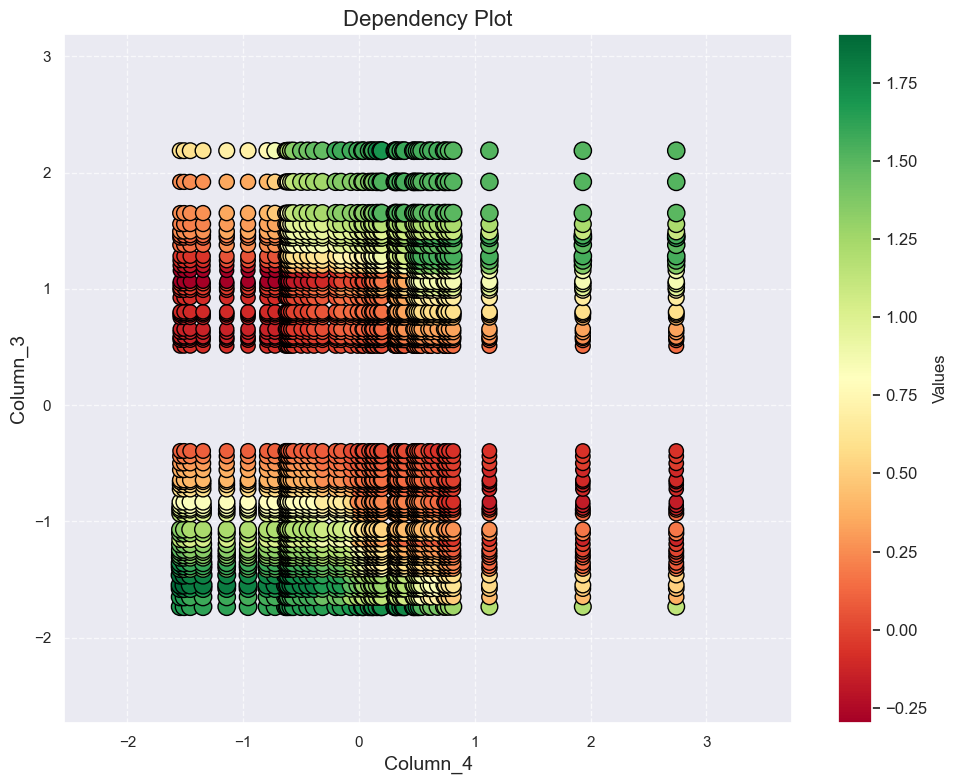

In [79]:
df = tree.analyze_dependency(4,3)
plot_dependecy(df)

In [76]:
df["values"] = 0.2 * np.sin(df["Column_3"]) * np.sin(df["Column_4"])
plot_dependecy(df)

KeyError: 'Column_3'

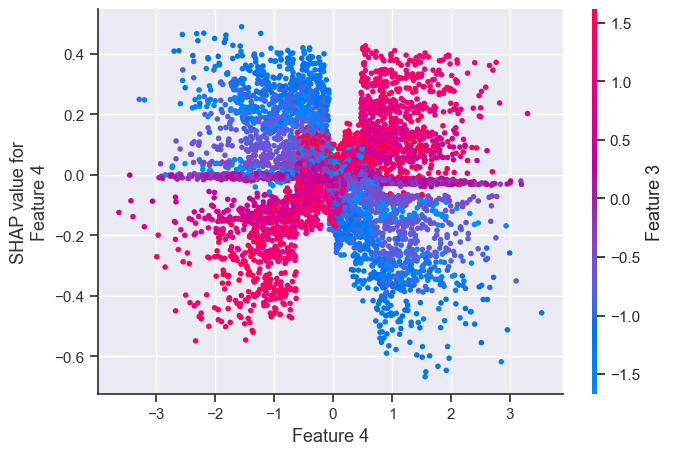

In [78]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X_train)

shap.dependence_plot(4, shap_values.values, X_train, interaction_index=3)